# IMPORT LIBRARY DAN SETUP

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# PEMBACAAN DAN PEMBERSIHAN DATA

In [38]:
# Baca data dari Excel
df = pd.read_excel('IPH Kota Batu.xlsx')

print("Data mentah:")
print(df.head(10))
print(f"Shape data mentah: {df.shape}")
print("Kolom yang tersedia:", df.columns.tolist())

# Bersihkan data dengan forward fill untuk kolom Bulan dan hapus missing values
df_clean = df.copy()

# Forward fill untuk kolom Bulan - ini akan mengisi nilai kosong dengan nilai sebelumnya
df_clean['Bulan'] = df_clean['Bulan'].fillna(method='ffill')

# Hapus baris yang tidak memiliki data indikator harga
df_clean = df_clean.dropna(subset=[' Indikator Perubahan Harga (%)'])

print(f"Data setelah pembersihan: {len(df_clean)} observasi")

# Tampilkan data awal untuk memastikan Januari dan Februari ada
print("\nData awal setelah pembersihan:")
print(df_clean[['Bulan', 'Minggu ke-', ' Indikator Perubahan Harga (%)']].head(10))

Data mentah:
      Bulan Minggu ke- Kab/Kota   Indikator Perubahan Harga (%)  \
0   Januari         M1     BATU                          -1.340   
1       NaN         M2     BATU                           0.930   
2  Februari         M2     BATU                           1.360   
3       NaN         M3     BATU                           1.820   
4       NaN         M4     BATU                           2.180   
5     Maret         M1     BATU                          -1.270   
6       NaN         M2     BATU                          -1.490   
7       NaN         M3     BATU                          -1.060   
8       NaN         M4     BATU                          -0.830   
9       NaN         M5     BATU                          -0.853   

                    Komoditas Andil Perubahan Harga   \
0  TELUR AYAM RAS(-0,773);PISANG(-0,333);DAGING A...   
1  CABAI RAWIT(0,063);MINYAK GORENG(0,054);CABAI ...   
2  BERAS(0,116);MINYAK GORENG(0,048);BAWANG MERAH...   
3  BERAS(0,116);MINYAK GO

# FUNGSI EKSTRAKSI WAKTU

In [39]:
def ekstrak_tahun(bulan_str):
    """Ekstrak tahun dari string bulan"""
    if pd.isna(bulan_str):
        return 2023
    
    bulan_str = str(bulan_str).strip()
    if "'24" in bulan_str:
        return 2024
    elif "'25" in bulan_str:
        return 2025
    else:
        # Jika tidak ada tanda petik, anggap sebagai 2023
        return 2023

def ekstrak_bulan(bulan_str):
    """Ekstrak nomor bulan dari nama bulan"""
    peta_bulan = {
        'januari': 1, 'februari': 2, 'maret': 3, 'april': 4,
        'mei': 5, 'juni': 6, 'juli': 7, 'agustus': 8,
        'september': 9, 'oktober': 10, 'november': 11, 'desember': 12
    }
    
    if pd.isna(bulan_str):
        return 1
    
    bulan_str = str(bulan_str).strip().lower()
    # Hapus tanda petik dan angka tahun jika ada
    bulan_bersih = bulan_str.split("'")[0].strip()
    
    for nama_bulan, nomor_bulan in peta_bulan.items():
        if nama_bulan in bulan_bersih:
            return nomor_bulan
    return 1

def ekstrak_minggu(minggu_str):
    """Ekstrak angka minggu dari format M1, M2, M3, M4, M5"""
    if pd.isna(minggu_str):
        return 1
    
    minggu_str = str(minggu_str).strip().upper()
    if minggu_str.startswith('M'):
        minggu_num = minggu_str.replace('M', '')
    else:
        minggu_num = minggu_str
    
    try:
        return int(minggu_num)
    except:
        return 1

def buat_tanggal(tahun, bulan, minggu):
    """Buat tanggal berdasarkan tahun, bulan, dan minggu ke-"""
    try:
        # Tanggal awal bulan
        tanggal_awal = datetime(tahun, bulan, 1)
        
        # Hitung tanggal berdasarkan minggu
        # Minggu ke-1 = tanggal 1-7, minggu ke-2 = tanggal 8-14, dst
        hari_dalam_minggu = (minggu - 1) * 7 + 1
        
        # Pastikan tidak melebihi hari dalam bulan
        if bulan == 2:  # Februari
            max_hari = 29 if tahun % 4 == 0 else 28
        elif bulan in [4, 6, 9, 11]:  # April, Juni, September, November
            max_hari = 30
        else:
            max_hari = 31
            
        if hari_dalam_minggu > max_hari:
            hari_dalam_minggu = max_hari
            
        tanggal_final = datetime(tahun, bulan, hari_dalam_minggu)
        return tanggal_final
    except Exception as e:
        print(f"Error creating date for {tahun}-{bulan}-{minggu}: {e}")
        return datetime(tahun, bulan, 1)

Fungsi: Membuat fungsi-fungsi untuk mengekstrak informasi waktu dari format data yang ada (tahun, bulan, minggu) dan mengkonversinya menjadi tanggal yang sesuai.

# PEMBUATAN KOLOM WAKTU DAN URUTAN

In [40]:
# Debug: Tampilkan beberapa contoh data bulan
print("Contoh data bulan:")
for i in range(min(10, len(df_clean))):
    print(f"Row {i}: '{df_clean.iloc[i]['Bulan']}' - '{df_clean.iloc[i]['Minggu ke-']}'")

# Buat kolom waktu menggunakan fungsi yang sudah diperbaiki
df_clean['Tahun'] = df_clean['Bulan'].apply(ekstrak_tahun)
df_clean['Bulan_Angka'] = df_clean['Bulan'].apply(ekstrak_bulan)
df_clean['Minggu_Angka'] = df_clean['Minggu ke-'].apply(ekstrak_minggu)

# Debug: Periksa hasil ekstraksi
print("\nHasil ekstraksi tahun dan bulan:")
debug_df = df_clean[['Bulan', 'Minggu ke-', 'Tahun', 'Bulan_Angka', 'Minggu_Angka']].head(10)
print(debug_df)

# Buat kolom tanggal
df_clean['Tanggal'] = df_clean.apply(lambda row: buat_tanggal(row['Tahun'], row['Bulan_Angka'], row['Minggu_Angka']), axis=1)

# Urutkan data berdasarkan tanggal dan buat periode berurutan
df_clean = df_clean.sort_values('Tanggal').reset_index(drop=True)
df_clean['Periode'] = range(1, len(df_clean) + 1)

print(f"\nPeriode data: {df_clean['Tanggal'].min()} sampai {df_clean['Tanggal'].max()}")
print(f"Total periode: {len(df_clean)} minggu")

# Tampilkan data awal untuk verifikasi
print("\nData awal setelah diurutkan:")
print(df_clean[['Periode', 'Tanggal', 'Bulan', 'Minggu ke-', ' Indikator Perubahan Harga (%)']].head(15))

Contoh data bulan:
Row 0: 'Januari' - 'M1'
Row 1: 'Januari' - 'M2'
Row 2: 'Februari' - 'M2'
Row 3: 'Februari' - 'M3'
Row 4: 'Februari' - 'M4'
Row 5: 'Maret' - 'M1'
Row 6: 'Maret' - 'M2'
Row 7: 'Maret' - 'M3'
Row 8: 'Maret' - 'M4'
Row 9: 'Maret' - 'M5'

Hasil ekstraksi tahun dan bulan:
      Bulan Minggu ke-  Tahun  Bulan_Angka  Minggu_Angka
0   Januari         M1   2023            1             1
1   Januari         M2   2023            1             2
2  Februari         M2   2023            2             2
3  Februari         M3   2023            2             3
4  Februari         M4   2023            2             4
5     Maret         M1   2023            3             1
6     Maret         M2   2023            3             2
7     Maret         M3   2023            3             3
8     Maret         M4   2023            3             4
9     Maret         M5   2023            3             5

Periode data: 2023-01-01 00:00:00 sampai 2025-06-22 00:00:00
Total periode: 118 minggu

Fungsi: Menerapkan fungsi ekstraksi waktu untuk membuat kolom tahun, bulan, minggu, tanggal, dan periode yang berurutan untuk keperluan time series.

# PERSIAPAN DATA UNTUK MODELING

In [41]:
# Pilih kolom yang diperlukan untuk modeling saja
modeling_data = df_clean[['Periode', 'Tanggal', 'Bulan', 'Minggu ke-', 
                         ' Indikator Perubahan Harga (%)', 'Tahun', 'Bulan_Angka', 'Minggu_Angka']].copy()

# Rename kolom untuk kemudahan
modeling_data.columns = ['Periode', 'Tanggal', 'Bulan', 'Minggu', 'Indikator_Harga', 'Tahun', 'Bulan_Numerik', 'Minggu_Dalam_Bulan']

# Konversi ke numerik
modeling_data['Indikator_Harga'] = pd.to_numeric(modeling_data['Indikator_Harga'], errors='coerce')

# Hapus baris dengan nilai NaN pada Indikator_Harga
modeling_data = modeling_data.dropna(subset=['Indikator_Harga'])

print("Dataset untuk modeling siap:")
print(modeling_data.head(15))
print(f"Shape data: {modeling_data.shape}")

# Verifikasi data Januari dan Februari 2023
jan_feb_2023 = modeling_data[(modeling_data['Tahun'] == 2023) & 
                            (modeling_data['Bulan_Numerik'].isin([1, 2]))]
print(f"\nData Januari-Februari 2023: {len(jan_feb_2023)} observasi")
if len(jan_feb_2023) > 0:
    print(jan_feb_2023[['Periode', 'Tanggal', 'Bulan', 'Minggu', 'Indikator_Harga']])

Dataset untuk modeling siap:
    Periode    Tanggal     Bulan Minggu  Indikator_Harga  Tahun  \
0         1 2023-01-01   Januari     M1           -1.340   2023   
1         2 2023-01-08   Januari     M2            0.930   2023   
2         3 2023-02-08  Februari     M2            1.360   2023   
3         4 2023-02-15  Februari     M3            1.820   2023   
4         5 2023-02-22  Februari     M4            2.180   2023   
5         6 2023-03-01     Maret     M1           -1.270   2023   
6         7 2023-03-08     Maret     M2           -1.490   2023   
7         8 2023-03-15     Maret     M3           -1.060   2023   
8         9 2023-03-22     Maret     M4           -0.830   2023   
9        10 2023-03-29     Maret     M5           -0.853   2023   
10       11 2023-04-01     April     M1           -1.786   2023   
11       12 2023-04-08     April     M2           -1.786   2023   
12       13 2023-04-22     April     M4           -1.786   2023   
13       14 2023-05-01       Mei 

Fungsi: Menyiapkan dataset khusus untuk modeling dengan hanya mengambil kolom yang diperlukan dan melakukan konversi tipe data yang sesuai.

# PEMBUATAN FITUR LAG DAN MOVING AVERAGE

In [42]:
# Tambah lag features (nilai periode sebelumnya)
for lag in [1, 2, 3, 4]:
    modeling_data[f'Lag_{lag}'] = modeling_data['Indikator_Harga'].shift(lag)

# Tambah moving averages (rata-rata bergerak)
modeling_data['MA_3'] = modeling_data['Indikator_Harga'].rolling(window=3).mean()
modeling_data['MA_7'] = modeling_data['Indikator_Harga'].rolling(window=7).mean()

# Hapus missing values yang terbentuk dari lag dan moving average
modeling_data_clean = modeling_data.dropna()

print(f"Data dengan fitur lag: {len(modeling_data_clean)} observasi")
print("Fitur yang tersedia untuk modeling:", [col for col in modeling_data_clean.columns if col not in ['Periode', 'Tanggal', 'Bulan', 'Minggu']])

# Tampilkan data awal setelah penambahan fitur lag
print("\nData awal setelah penambahan fitur lag:")
print(modeling_data_clean[['Periode', 'Tanggal', 'Bulan', 'Minggu', 'Indikator_Harga', 'Lag_1', 'Lag_2']].head(10))


Data dengan fitur lag: 112 observasi
Fitur yang tersedia untuk modeling: ['Indikator_Harga', 'Tahun', 'Bulan_Numerik', 'Minggu_Dalam_Bulan', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'MA_3', 'MA_7']

Data awal setelah penambahan fitur lag:
    Periode    Tanggal  Bulan Minggu  Indikator_Harga  Lag_1  Lag_2
6         7 2023-03-08  Maret     M2           -1.490 -1.270  2.180
7         8 2023-03-15  Maret     M3           -1.060 -1.490 -1.270
8         9 2023-03-22  Maret     M4           -0.830 -1.060 -1.490
9        10 2023-03-29  Maret     M5           -0.853 -0.830 -1.060
10       11 2023-04-01  April     M1           -1.786 -0.853 -0.830
11       12 2023-04-08  April     M2           -1.786 -1.786 -0.853
12       13 2023-04-22  April     M4           -1.786 -1.786 -1.786
13       14 2023-05-01    Mei     M1            0.189 -1.786 -1.786
14       15 2023-05-08    Mei     M2            0.508  0.189 -1.786
15       16 2023-05-15    Mei     M3            0.718  0.508  0.189


Fungsi: Membuat fitur lag (nilai periode sebelumnya) dan moving average yang penting untuk prediksi time series, kemudian membersihkan data dari missing values.

# VISUALISASI TIME SERIES

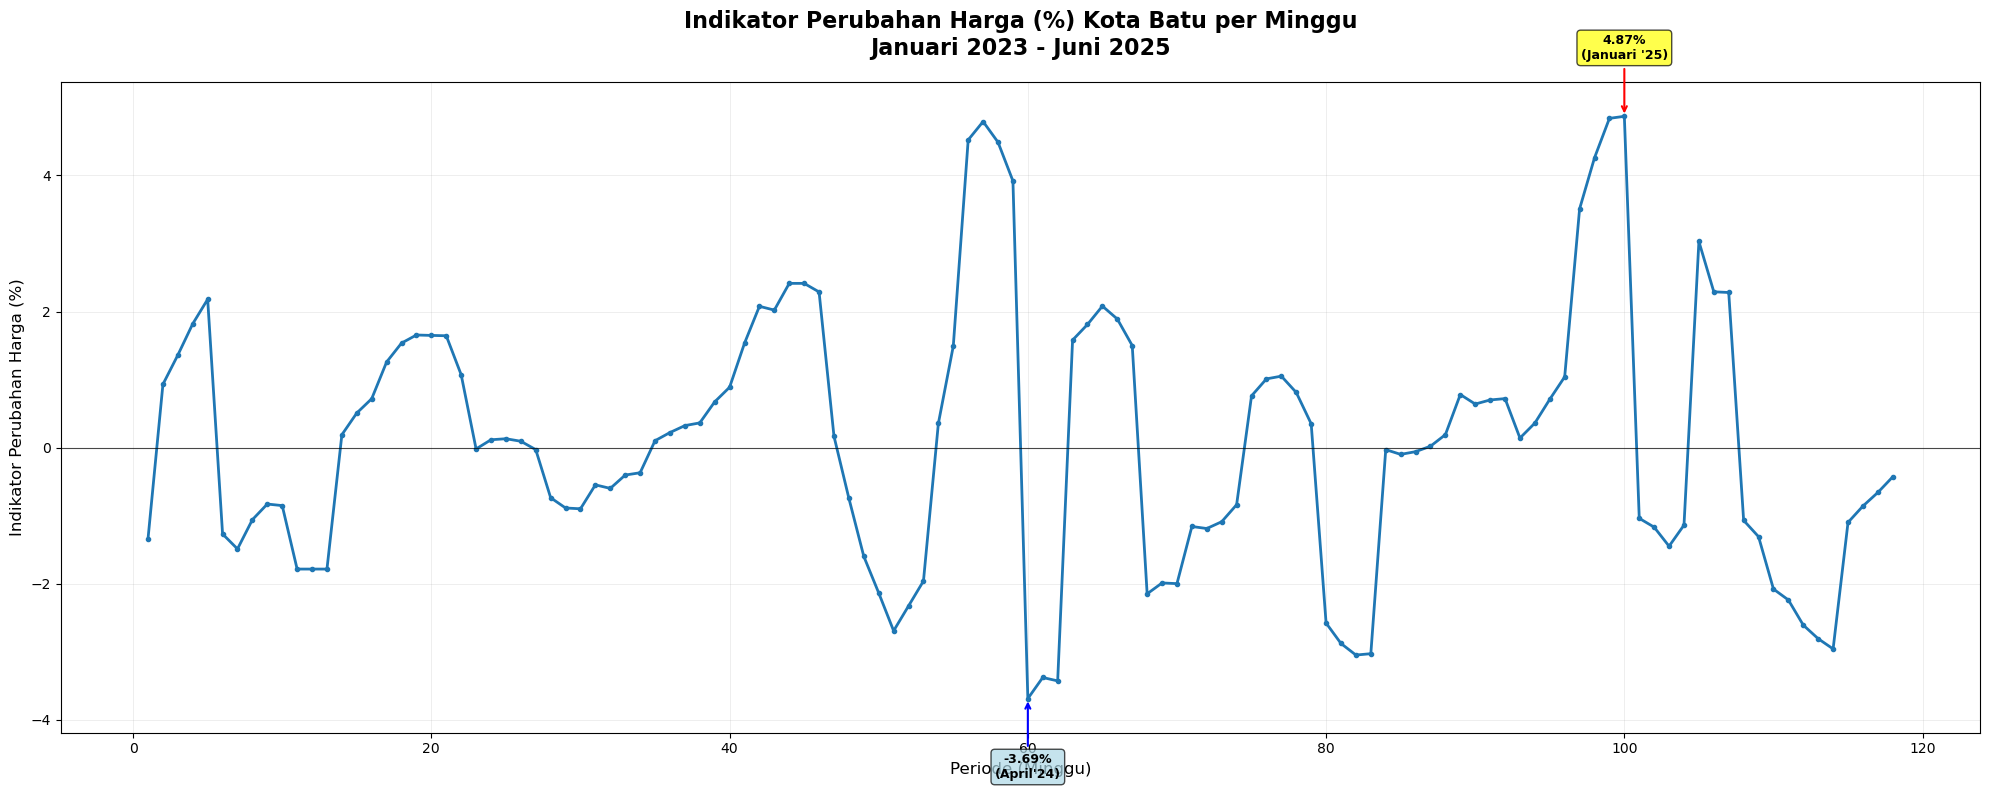

In [43]:
# Setup plotting
plt.style.use('default')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

# Buat plot time series
fig, ax = plt.subplots(figsize=(20, 8))

# Plot garis utama - gunakan data lengkap sebelum lag
ax.plot(modeling_data['Periode'], modeling_data['Indikator_Harga'], 
        color='#1f77b4', linewidth=2, marker='o', markersize=3)

# Tambahkan grid dan formatting
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Set labels dan title
ax.set_title('Indikator Perubahan Harga (%) Kota Batu per Minggu\nJanuari 2023 - Juni 2025', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Periode (Minggu)', fontsize=12)
ax.set_ylabel('Indikator Perubahan Harga (%)', fontsize=12)

# Set range dan garis horizontal di y=0
y_min = modeling_data['Indikator_Harga'].min() - 0.5
y_max = modeling_data['Indikator_Harga'].max() + 0.5
ax.set_ylim(y_min, y_max)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

# Annotate titik maksimum dan minimum
max_idx = modeling_data['Indikator_Harga'].idxmax()
min_idx = modeling_data['Indikator_Harga'].idxmin()

max_val = modeling_data.loc[max_idx, 'Indikator_Harga']
min_val = modeling_data.loc[min_idx, 'Indikator_Harga']
max_periode = modeling_data.loc[max_idx, 'Periode']
min_periode = modeling_data.loc[min_idx, 'Periode']
max_bulan = modeling_data.loc[max_idx, 'Bulan']
min_bulan = modeling_data.loc[min_idx, 'Bulan']

ax.annotate(f'{max_val:.2f}%\n({max_bulan})', 
            xy=(max_periode, max_val), 
            xytext=(max_periode, max_val + 0.8),
            ha='center', va='bottom', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

ax.annotate(f'{min_val:.2f}%\n({min_bulan})', 
            xy=(min_periode, min_val), 
            xytext=(min_periode, min_val - 0.8),
            ha='center', va='top', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))

plt.tight_layout()
plt.show()

Fungsi: Membuat visualisasi time series yang informatif dengan menampilkan tren data, titik maksimum dan minimum, serta formatting yang baik untuk analisis visual.

# SPLIT DATA TRAINING DAN TESTING

In [44]:
# Buat folder dataset jika belum ada
dataset_folder = 'dataset'
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    print(f"Folder '{dataset_folder}' berhasil dibuat")

# Split data 80-20 untuk training-testing
split_point = int(0.8 * len(modeling_data_clean))

train_data = modeling_data_clean.iloc[:split_point].copy()
test_data = modeling_data_clean.iloc[split_point:].copy()

print(f"Training data: {len(train_data)} observasi")
print(f"Testing data: {len(test_data)} observasi")
print(f"Periode training: {train_data['Tanggal'].min()} sampai {train_data['Tanggal'].max()}")
print(f"Periode testing: {test_data['Tanggal'].min()} sampai {test_data['Tanggal'].max()}")

# Simpan data untuk modeling
train_file = os.path.join(dataset_folder, 'data_iph_training.csv')
test_file = os.path.join(dataset_folder, 'data_iph_testing.csv')
modeling_data_clean.to_csv('data_iph_modeling.csv', index=False)

train_data.to_csv(train_file, index=False)
test_data.to_csv(test_file, index=False)

Folder 'dataset' berhasil dibuat
Training data: 89 observasi
Testing data: 23 observasi
Periode training: 2023-03-08 00:00:00 sampai 2024-12-15 00:00:00
Periode testing: 2024-12-22 00:00:00 sampai 2025-06-22 00:00:00


Fungsi: Membagi data menjadi training set (80%) dan testing set (20%) untuk evaluasi model, serta menyimpan dataset yang siap untuk modeling.

# SUMMARY STATISTIK DAN INFORMASI FINAL

In [45]:
# Buat summary statistik
summary_stats = {
    'Total_Observasi': len(modeling_data_clean),
    'Training_Data': len(train_data),
    'Testing_Data': len(test_data),
    'Periode_Awal': modeling_data_clean['Tanggal'].min().strftime('%Y-%m-%d'),
    'Periode_Akhir': modeling_data_clean['Tanggal'].max().strftime('%Y-%m-%d'),
    'Nilai_Minimum': modeling_data_clean['Indikator_Harga'].min(),
    'Nilai_Maksimum': modeling_data_clean['Indikator_Harga'].max(),
    'Rata_rata': modeling_data_clean['Indikator_Harga'].mean(),
    'Standar_Deviasi': modeling_data_clean['Indikator_Harga'].std()
}

print("SUMMARY STATISTIK IPH KOTA BATU:")
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Tampilkan distribusi data per tahun
print(f"\nDistribusi data per tahun:")
tahun_counts = modeling_data_clean['Tahun'].value_counts().sort_index()
for tahun, count in tahun_counts.items():
    print(f"Tahun {tahun}: {count} observasi")

# Tampilkan distribusi data per bulan untuk tahun 2023
print(f"\nDistribusi data 2023 per bulan:")
data_2023 = modeling_data_clean[modeling_data_clean['Tahun'] == 2023]
bulan_2023_counts = data_2023['Bulan_Numerik'].value_counts().sort_index()
nama_bulan = ['', 'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']
for bulan_num, count in bulan_2023_counts.items():
    print(f"{nama_bulan[bulan_num]} 2023: {count} observasi")

# Tampilkan fitur untuk modeling
features_for_modeling = [col for col in modeling_data_clean.columns 
                        if col.startswith('Lag_') or col.startswith('MA_') or col in ['Bulan_Numerik', 'Minggu_Dalam_Bulan']]

print(f"\nFITUR UNTUK MODELING:")
print("Target variable: 'Indikator_Harga'")
print("Features available:", features_for_modeling)

print(f"\nContoh data awal (termasuk Jan-Feb 2023):")
print(modeling_data_clean[['Periode', 'Tanggal', 'Bulan', 'Minggu', 'Indikator_Harga']].head(10))

SUMMARY STATISTIK IPH KOTA BATU:
Total_Observasi: 112
Training_Data: 89
Testing_Data: 23
Periode_Awal: 2023-03-08
Periode_Akhir: 2025-06-22
Nilai_Minimum: -3.6900
Nilai_Maksimum: 4.8700
Rata_rata: 0.0688
Standar_Deviasi: 1.9399

Distribusi data per tahun:
Tahun 2023: 40 observasi
Tahun 2024: 50 observasi
Tahun 2025: 22 observasi

Distribusi data 2023 per bulan:
Maret 2023: 4 observasi
April 2023: 3 observasi
Mei 2023: 5 observasi
Juni 2023: 4 observasi
Juli 2023: 4 observasi
Agustus 2023: 4 observasi
September 2023: 4 observasi
Oktober 2023: 4 observasi
November 2023: 4 observasi
Desember 2023: 4 observasi

FITUR UNTUK MODELING:
Target variable: 'Indikator_Harga'
Features available: ['Bulan_Numerik', 'Minggu_Dalam_Bulan', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'MA_3', 'MA_7']

Contoh data awal (termasuk Jan-Feb 2023):
    Periode    Tanggal  Bulan Minggu  Indikator_Harga
6         7 2023-03-08  Maret     M2           -1.490
7         8 2023-03-15  Maret     M3           -1.060
8         9

Fungsi: Memberikan ringkasan statistik lengkap, menampilkan fitur yang tersedia untuk modeling, dan memberikan informasi final tentang file yang dihasilkan untuk tahap modeling selanjutnya.